In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
    NegativeLowerConfidenceBound, MaxValueEntropySearch
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

from utils import x_scaler, x_descaler, define_parameter_space, get_rbf_kernel, \
    get_gpr_model, get_matern52_kernel, generate_visualization_efficiency_vs_ml_conditions, \
    generate_contour_plot, generate_visualization_process_conditions, compute_group_means
from utils import ScaledProbabilityOfFeasibility, ProbabilisticConstraintBayesianOptimizationLoop2

np.random.seed(10)

In [2]:
# Assuming your data is in an Excel file named 'your_data.xlsx'.
file_path = './main_data.xlsx'

df_film1 = pd.read_excel(file_path, sheet_name='2022_07_15_film')
df_film2 = pd.read_excel(file_path, sheet_name='2022_07_21_film-new')

df_film = pd.concat([df_film1, df_film2], ignore_index = True)

# Renaming the columns
df_film.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 
                   'Perovskite concentration (M)',  'Annealing temperature (℃)', 
                   'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 
                   'Humidity (%)', 'Success or Fail']

# Filter the successful conditions
success_conditions = df_film[df_film['Success or Fail'] == 1]['Condition'].values

# Display the DataFrame
df_film

,Condition,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%),Success or Fail
0,1,0,100,0,0.80,110,200,20,25,30,0
1,2,100,0,0,1.30,100,250,25,25,30,1
2,3,0,0,100,1.20,115,100,20,25,30,0
3,4,15,85,0,1.40,125,100,15,25,30,1
4,5,0,15,85,1.10,135,120,17,25,30,1
5,6,15,85,0,1.50,145,100,15,25,30,1
6,7,0,85,15,1.65,155,50,15,25,30,1
7,8,85,0,15,1.70,105,200,15,25,30,1
8,9,15,0,85,1.15,115,100,20,25,30,0
9,10,70,30,0,1.25,120,100,5,25,30,0


In [3]:
# Assuming your data is in an Excel file named 'your_data.xlsx' and the sheet name is '2022-device'.
file_path = './main_data.xlsx'

df_device1 = pd.read_excel(file_path, sheet_name='2022_07_15_device')
df_device2 = pd.read_excel(file_path, sheet_name='2022_07_21_device-new')

df_device = pd.concat([df_device1, df_device2], ignore_index = True)

df_device.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 
                     'Perovskite concentration (M)', 'Annealing temperature (℃)', 
                     'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 
                     'Temperature (℃)', 'Humidity (%)', 'Voc(V)', 'FF(%)', 
                     'Eff(%)', 'Jsc(mA/cm^2)']

# Filter data based on success_conditions
success_conditions = [2, 4, 5, 6, 7, 8, 11, 12, 17, 18] + list(range(21,41))

df_device = df_device.sort_values(by=list(df_device.iloc[:,[0,-1]].columns))
df_device = df_device[df_device['Condition'].isin(success_conditions)]

# take the mean of the measurements
df_device = compute_group_means(df_device)

# Display the DataFrame
df_device

,Condition,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%),Voc(V),FF(%),Eff(%),Jsc(mA/cm^2)
0,2,100,0,0,1.30,100,250,25,25,30,0.990840,68.372500,15.208100,24.929150
1,4,15,85,0,1.40,125,100,15,25,30,0.927814,72.167550,17.584025,25.371675
2,5,0,15,85,1.10,135,120,17,25,30,1.012060,73.626850,18.687275,25.437650
3,6,15,85,0,1.50,145,100,15,25,30,0.917055,64.097075,14.670875,25.018525
4,7,0,85,15,1.65,155,50,15,25,30,1.050000,76.610175,20.064050,25.129866
5,8,85,0,15,1.70,105,200,15,25,30,1.050000,65.892725,15.399400,23.619785
6,11,0,30,70,1.30,130,80,35,25,30,1.000000,71.424875,18.216725,25.224007
7,12,30,70,0,1.35,135,200,18,25,30,0.930592,39.721275,7.814825,24.626475
8,17,55,45,0,1.00,125,70,45,25,30,0.884523,61.404125,13.864700,24.951775
9,18,45,55,0,1.20,115,270,47,25,30,0.974575,62.769775,10.863735,23.247075


In [4]:
print(len(df_device))

30


In [5]:
# Load the dataset
df_previous = pd.read_excel("./preliminary_data.xlsx")

# Change the column names
df_previous.columns = [
    '',
    'NMP (mL)',
    'DMF (mL)',
    'DMSO (mL)',
    'Perovskite concentration (M)',
    'Annealing temperature (℃)',
    'Vacuum Pressure (Pa)',
    'Vacuum Pressure time (s)',
    'Temperature (℃)',
    'Humidity (%)',
    'Voc(V)',
    'FF(%)',
    'Eff(%)',
    'Jsc(mA/cm^2)'
]

# Remove the first column
df_previous = df_previous.iloc[:, 1:]

#df_previous

In [6]:
NMP_options = np.arange(0,101,5) 
DMF_options = np.arange(0,101,5)
DMSO_options = np.arange(0,101,5)
PC_options = np.arange(0.8,1.81,0.1)
AT_options = np.arange(100,161,5)
VP_options = np.arange(20,401,10)
VT_options = np.arange(5,56,2)

# total number of conditions in search space
print(len(NMP_options) * len(DMF_options) * len(DMSO_options) * len(PC_options) * len(AT_options)
     * len(VP_options) * len(VT_options))

# needed for scaling
descaled_search_space = [NMP_options, DMF_options,
DMSO_options, PC_options,
AT_options, VP_options,
VT_options]

1342863522


In [7]:
parameter_space = define_parameter_space(NMP_options, DMF_options, DMSO_options, PC_options, AT_options, \
                                         VP_options, VT_options)

In [8]:
# Preprocess your data
x_init = x_scaler(df_device.iloc[:, 1:8].values, descaled_search_space)
y_init = np.transpose([df_device.iloc[:, -2].values])
xc_init = x_scaler(df_film.iloc[:, 1:-3].values, descaled_search_space)
yc_init = np.transpose([df_film.iloc[:, -1].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_scaler(df_previous.iloc[:,0:7].values, descaled_search_space)
Yc2 = np.transpose([df_previous.iloc[:,-2].values])

# get objective model
input_dim = len(X[0])
ker = get_matern52_kernel(input_dim)
model_gpy = get_gpr_model(X, Y, ker, set_noise=True)
objective_model = GPyModelWrapper(model_gpy)

# get constraint model 1
input_dim_c = len(Xc[0])
ker_c = get_rbf_kernel(input_dim_c)
yc_offset = 0.5 # constraint acquisition computes the probability of < 0
gpy_constraint_model = get_gpr_model(Xc, Yc-yc_offset, ker_c) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

# get_constraint_model 2
input_dim_c2 = len(Xc2[0])
ker_c2 = get_rbf_kernel(input_dim_c2)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of < 0
gpy_constraint_model2 = get_gpr_model(Xc2, Yc2-yc2_offset, ker_c2) 
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


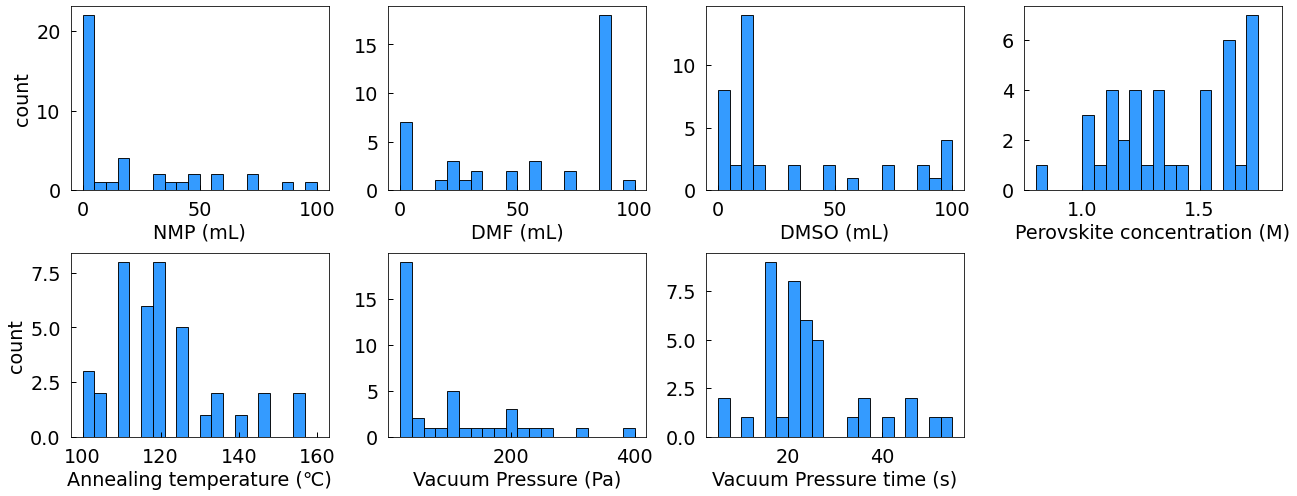

In [9]:
#visualize the distribution of the initial batch across the search space
generate_visualization_process_conditions(df_film.iloc[:, 1:8], descaled_search_space, 'batch2')

In [10]:
objective_model.model.kern.lengthscale

index,GP_regression.Mat52.lengthscale,constraints,priors
[0],1.00000000,"0.1,1.0",
[1],1.00000000,"0.1,1.0",
[2],1.00000000,"0.1,1.0",
[3],1.00000000,"0.1,1.0",
[4],0.99999997,"0.1,1.0",
[5],0.66238277,"0.1,1.0",
[6],1.00000000,"0.1,1.0",


# Start the Second Run of the Batch-mode Bayesian Optimization

In [11]:
## Expeceted Improvement (EI)
#acquisition = ExpectedImprovement(objective_model, jitter=.1)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
## Max value entropy search
#acquisition = MaxValueEntropySearch(objective_model, parameter_space, 100)

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size=80) # take 100 since there will be duplicates

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
X_new = x_descaler(X_new, descaled_search_space)

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))

total condition no.: 40
total device no.: 30
maximum Y (PCE [%]):  22.63


In [12]:
df_Xnew = pd.DataFrame(X_new, columns = df_film.columns[1:8])
print(len(df_Xnew))
df_Xnew = df_Xnew.drop_duplicates(keep='first')
df_Xnew = df_Xnew[~df_Xnew.apply(tuple, axis=1).isin(df_film[df_film.columns[1:8]].apply(tuple, axis=1))]
print('total sample no.:', len(df_Xnew))

#downsample to 20 experiments
df_Xnew = df_Xnew[:20]

80
total sample no.: 21


In [13]:
df_Xnew.reset_index(inplace=True)
df_Xnew.set_index(np.array(df_Xnew.index) + 41, inplace=True)
#df_Xnew.index = df_Xnew.index.apply(lambda x: x + 41)
df_Xnew = df_Xnew[[column for column in df_Xnew.columns if column != 'level_0' and column != 'index']]

In [14]:
df_Xnew.to_excel('experiments_batch2.xlsx')

In [15]:
X_new = x_scaler(df_Xnew.values, descaled_search_space)

y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new
y_uncer_new = np.sqrt(y_uncer_new)

acq_produc = f_cons_acq(X_new)
acq_fcn = f_raw_acq(X_new)
acq_cons = f_cons_pr(X_new)

# Quick histogram visualization of the newly suggested process conditions

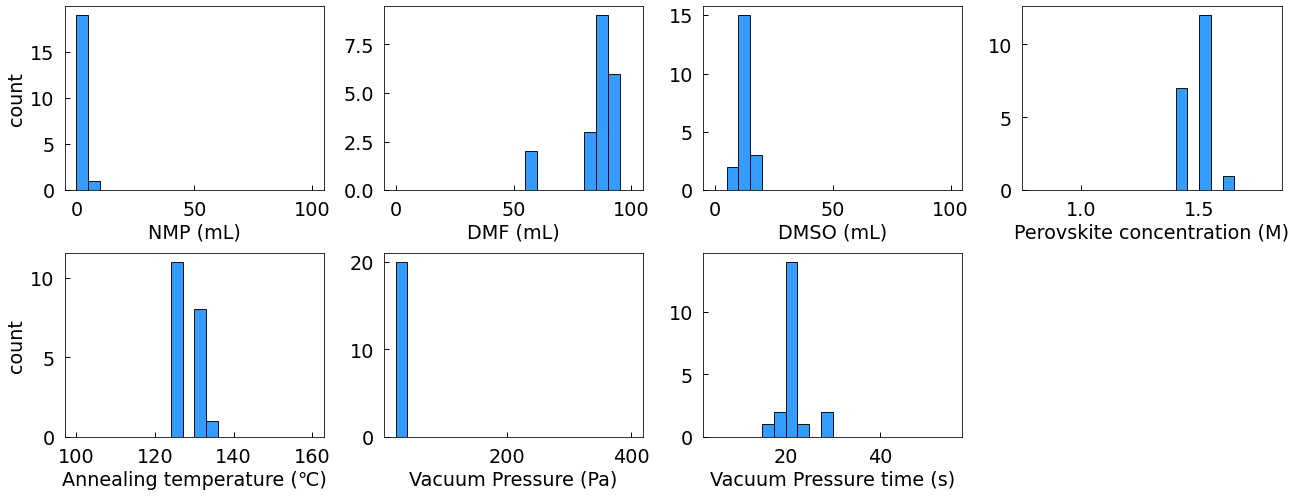

In [16]:
generate_visualization_process_conditions(df_Xnew, descaled_search_space, 'sampled_batch2')

# Visualisation of Efficiency vs ML conditions, and Acquisition¶

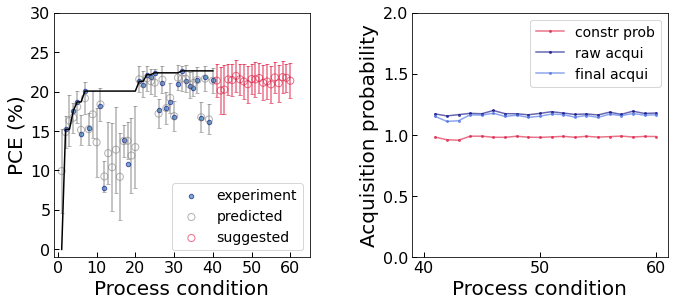

In [17]:
from emukit.core.initial_designs import RandomDesign

f_obj =  objective_model.model.predict       

generate_visualization_efficiency_vs_ml_conditions(X_new, Xc, df_device, df_film, f_obj, \
                                                   acq_fcn, acq_cons, acq_produc, descaled_search_space, xlim=65)

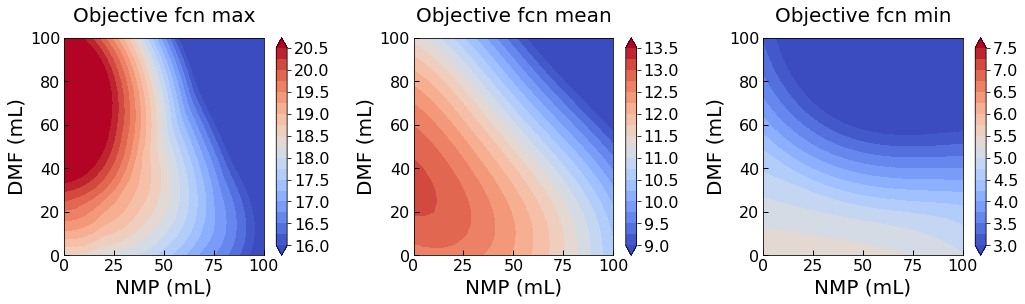

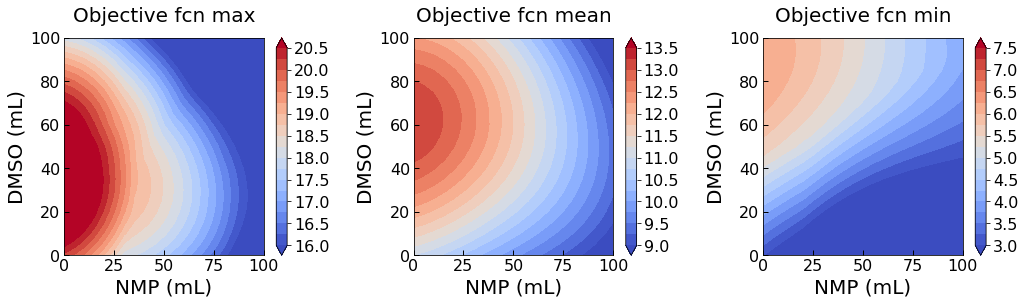

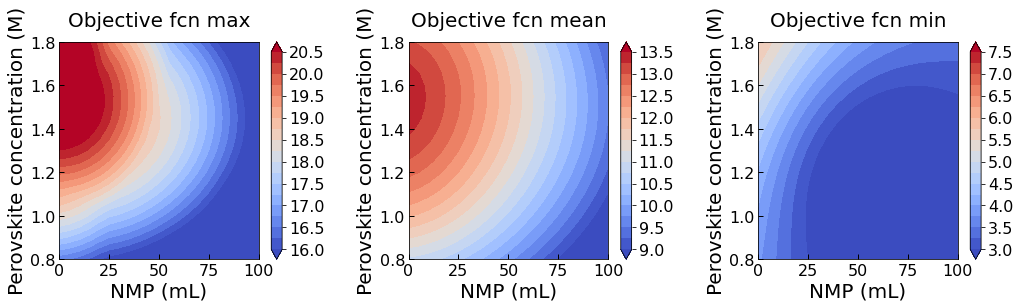

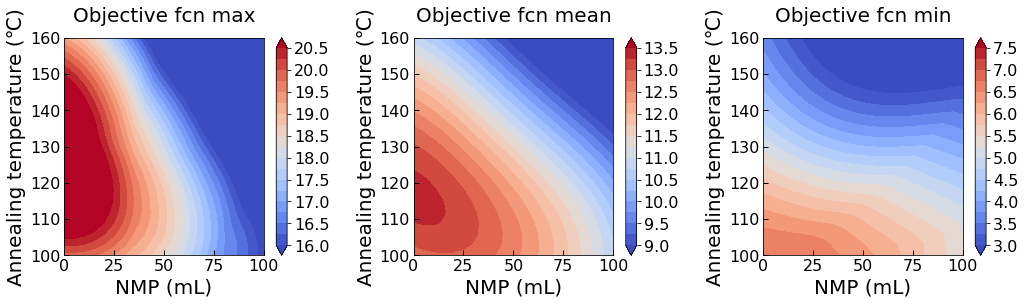

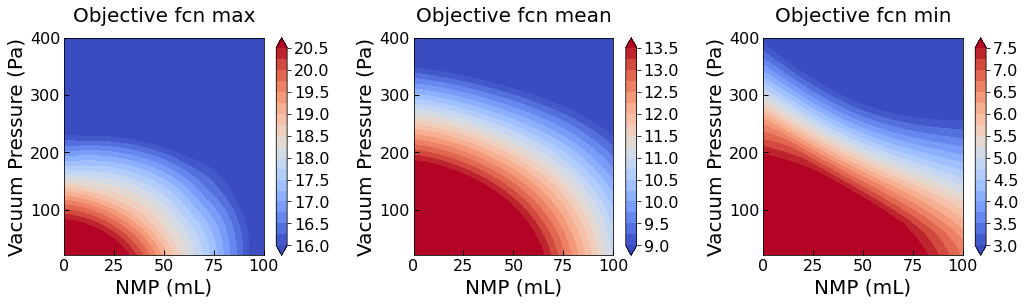

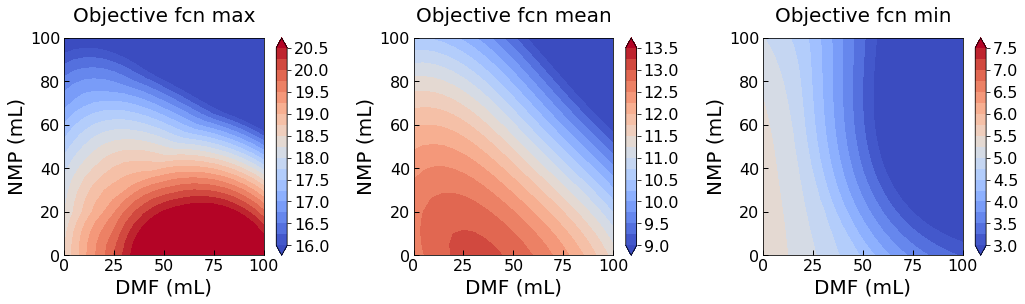

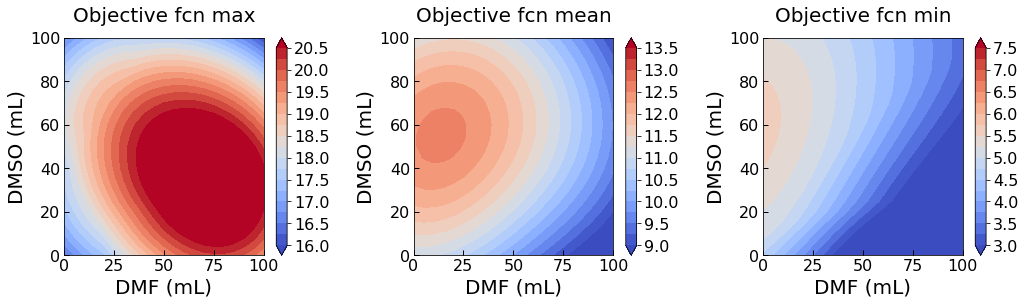

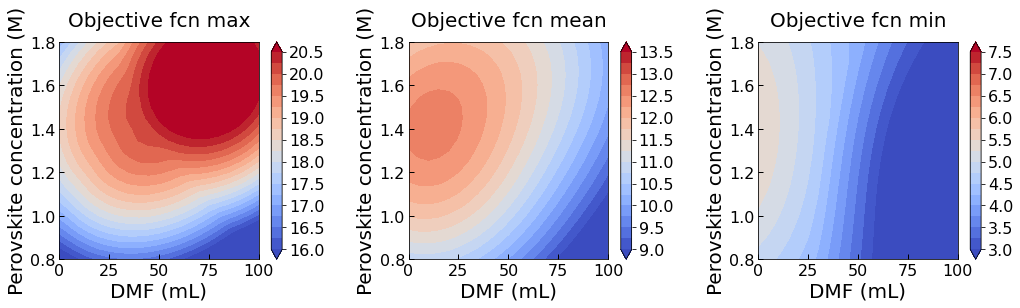

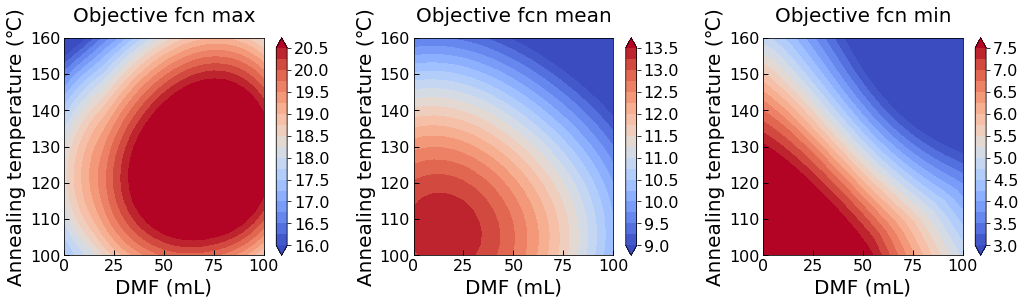

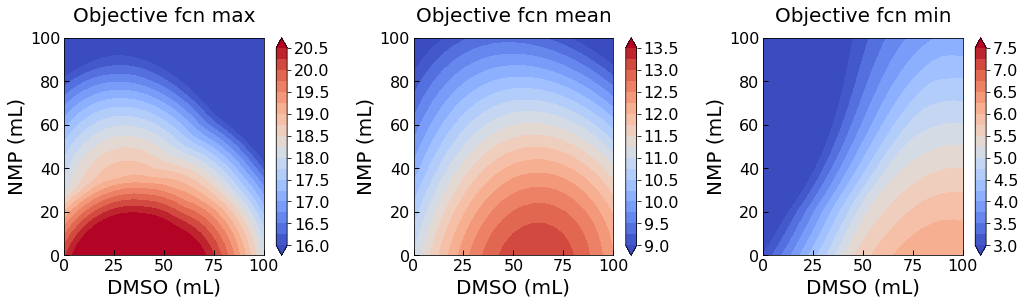

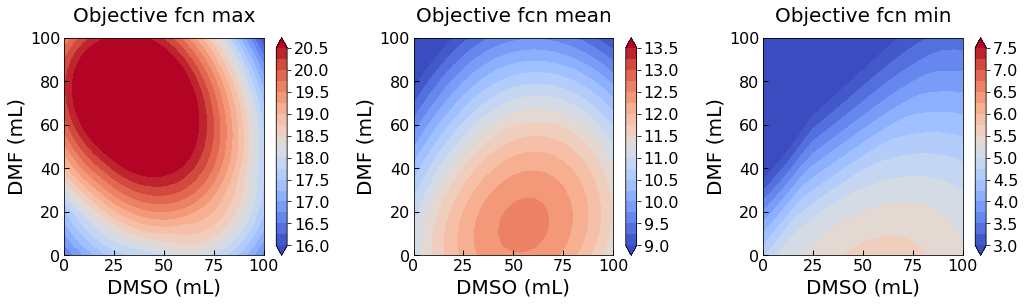

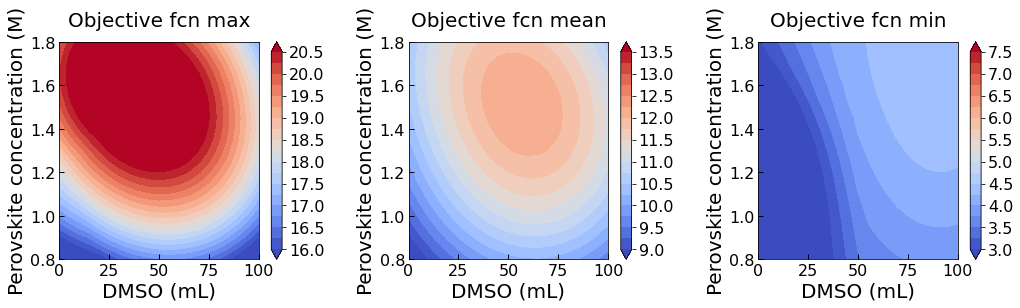

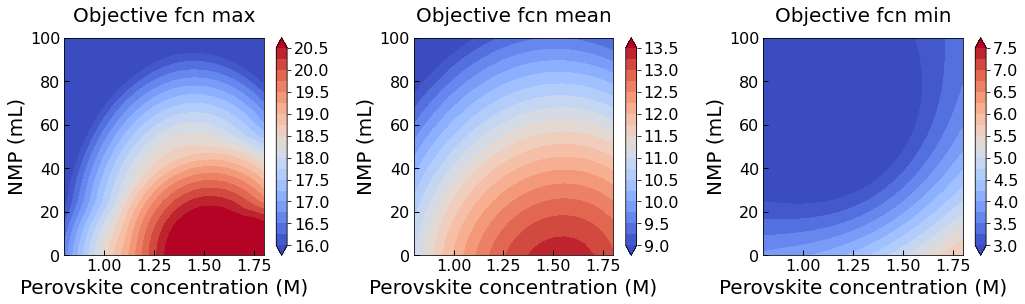

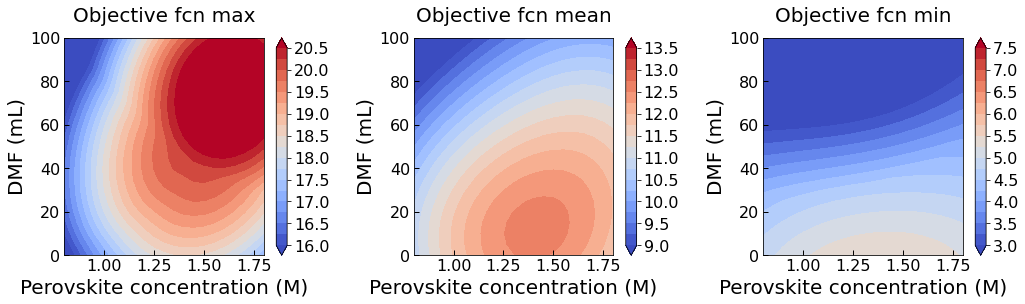

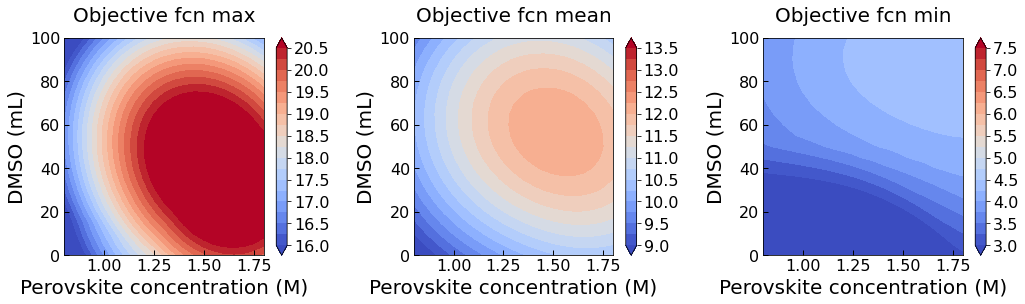

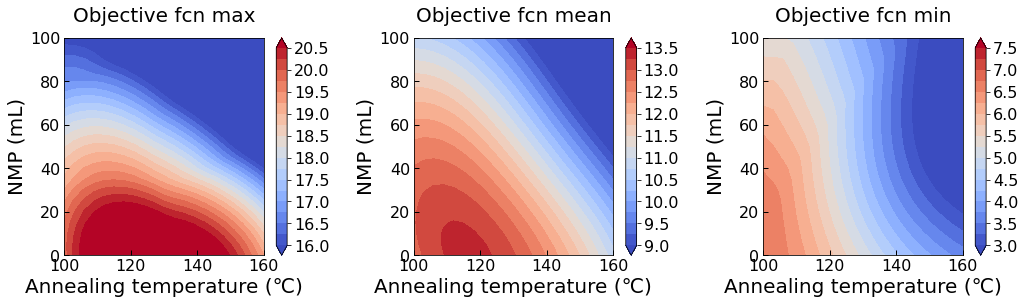

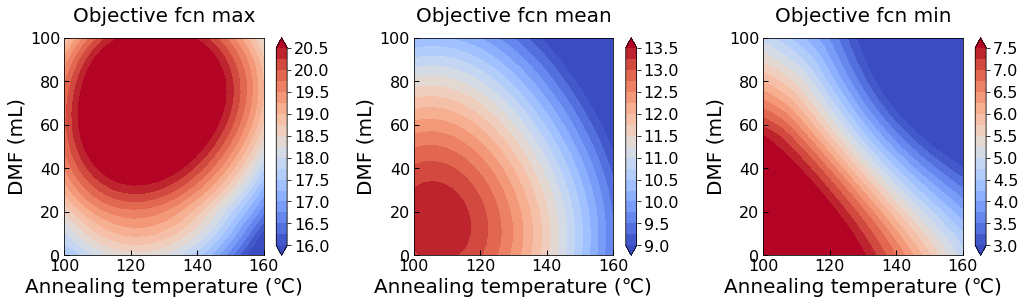

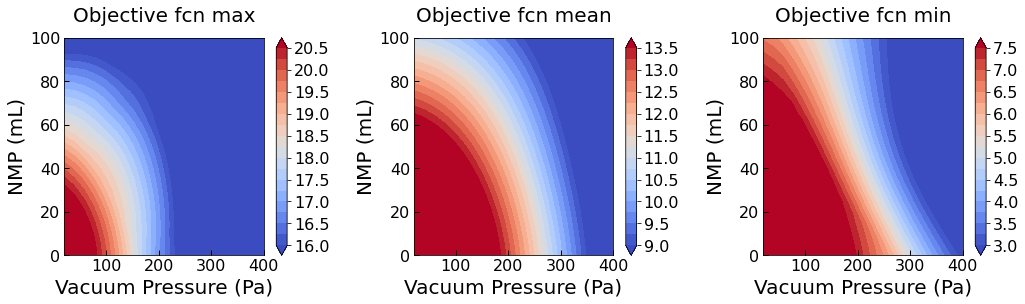

In [18]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(500)
x_columns = df_device.iloc[:,1 :10].columns

for i in range(0, input_dim, 1):
    for j in range(0, input_dim-i-1, 1):
        if i != j:
            generate_contour_plot(i, j, x_sampled, f_obj, x_descaler, x_columns, descaled_search_space)